In [1]:
import torch.nn.functional as F
import sys
try:
    import dask
    import dask.dataframe as dd
    print(f"Dask version: {dask.__version__}")
    print("Dask dataframe imported successfully.")
except ImportError as e:
    print(f"Error importing dask: {e}")
    sys.exit(1)

try:
    import torch
    print(f"Torch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
except ImportError as e:
    print(f"Error importing torch: {e}")


Dask version: 2025.11.0
Dask dataframe imported successfully.
Torch version: 2.9.1+cu128
CUDA available: True


# Documentación del Modelo de Predicción de Tráfico (ST-DenseNet)

Este documento detalla la arquitectura, formulación matemática y metodología utilizada en el modelo de predicción de tráfico celular (SMS) para la ciudad de Milán. El modelo se basa en una arquitectura **ST-DenseNet** (Spatio-Temporal Densely Connected Convolutional Network).

## 1. Definición del Problema

El objetivo es predecir el volumen de tráfico de SMS (entrante y saliente) para cada celda de una cuadrícula de $100 \times 100$ en la ciudad de Milán para el siguiente intervalo de tiempo, basándose en datos históricos.

Sea $X_t \in \mathbb{R}^{2 \times 100 \times 100}$ el tensor de tráfico en el tiempo $t$, donde el canal 0 representa `smsin` y el canal 1 representa `smsout`. El objetivo es aprender una función $f$ tal que:

$$ \hat{X}_{t} = f(X_{t-1}, X_{t-2}, \dots, X_{t-n}) $$

In [2]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración del Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Parámetros del Modelo
H, W = 100, 100  # Dimensiones de la cuadrícula
LEN_CLOSE = 3    # Dependencia de proximidad (p)
LEN_PERIOD = 3   # Dependencia de periodo (q)
NB_FLOW = 1      # Canales (SMS In, SMS Out)

# Parámetros de Entrenamiento
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.01

Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 5080


## 2. Preprocesamiento de Datos

### 2.1. Agregación Espacio-Temporal
Los datos crudos se agregan espacialmente en una rejilla de $H \times W$ ($100 \times 100$) y temporalmente en intervalos de 1 hora.

### 2.2. Normalización Min-Max
Para facilitar la convergencia del entrenamiento, los datos se normalizan al rango $[0, 1]$ utilizando la transformación Min-Max:

$$ x'_{i} = \frac{x_i - \min(X)}{\max(X) - \min(X)} $$

Donde $x_i$ es el valor de tráfico en una celda y tiempo específico, y $X$ es el conjunto total de datos de entrenamiento.

### 2.1. Construcción del Grafo (Grid to Graph)
Convertimos la rejilla de 100x100 en un grafo donde cada celda es un nodo conectado a sus vecinos (arriba, abajo, izquierda, derecha).

In [3]:

import scipy.sparse as sp

# --- CONSTRUCCIÓN DEL GRAFO (SPARSE / EDGE INDEX) ---
def get_edge_index(h, w):
    rows = []
    cols = []
    for r in range(h):
        for c in range(w):
            idx = r * w + c
            # Vecinos: arriba, abajo, izq, der
            if r > 0: 
                rows.append((r-1)*w + c); cols.append(idx)
            if r < h-1: 
                rows.append((r+1)*w + c); cols.append(idx)
            if c > 0: 
                rows.append(r*w + c - 1); cols.append(idx)
            if c < w-1: 
                rows.append(r*w + c + 1); cols.append(idx)
                
    # Retornamos Tensor [2, E]
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    return edge_index

print("Construyendo lista de aristas (Sparse edge_index)...")
edge_index = get_edge_index(100, 100).to(DEVICE)
print(f"Edge Index Shape: {edge_index.shape}") # [2, ~40000]


Construyendo lista de aristas (Sparse edge_index)...
Edge Index Shape: torch.Size([2, 39600])


### 2.2. Normalización Z-Score
Se utiliza Z-Score ($x' = (x - \mu) / \sigma$) en lugar de Min-Max para una mejor distribución.

In [4]:
files = ['../data1.csv/data1.csv', '../data2.csv/data2.csv']
valid_files = [f for f in files if os.path.exists(f)]

print("Cargando y agregando datos (esto puede tardar)...")

# Cargar con Dask
ddf = dd.read_csv(valid_files, assume_missing=True)

# Convertir TimeInterval a datetime
ddf['Timestamp'] = dd.to_datetime(ddf['TimeInterval'], unit='ms')

# Redondear a la hora (Agregación Temporal)
ddf['Hour'] = ddf['Timestamp'].dt.floor('h')

# Seleccionar columnas de interés (SMS)
cols = ['Hour', 'GridID', 'internet']
ddf = ddf[cols]

# Agrupar por Hora y GridID
agg_task = ddf.groupby(['Hour', 'GridID'])[['internet']].sum()

with ProgressBar():
    df_agg = agg_task.compute().reset_index()

print("Agregación completada.")
print(df_agg.head())

Cargando y agregando datos (esto puede tardar)...
[########################################] | 100% Completed | 137.40 s
Agregación completada.
                 Hour  GridID     internet
0 2013-11-22 23:00:00   455.0   125.532132
1 2013-11-22 23:00:00   483.0    37.542953
2 2013-11-22 23:00:00  4331.0   112.846020
3 2013-11-22 23:00:00  4354.0  4040.640210
4 2013-11-22 23:00:00  4386.0    54.041229


In [5]:
# --- CONSTRUCCIÓN DE LA MATRIZ 4D (Time, Channels, H, W) ---

# Filtrar GridIDs válidos (1 a 10000)
df_agg = df_agg[(df_agg['GridID'] >= 1) & (df_agg['GridID'] <= 10000)]

# Crear índice temporal completo
min_time = df_agg['Hour'].min()
max_time = df_agg['Hour'].max()
time_range = pd.date_range(min_time, max_time, freq='H')

print(f"Rango temporal: {min_time} a {max_time} ({len(time_range)} horas)")

# Inicializar tensor gigante: [Time, 2, 100, 100]
data_tensor = np.zeros((len(time_range), 1, 100, 100), dtype=np.float32)

# Mapeo de tiempo a índice
time_to_idx = {t: i for i, t in enumerate(time_range)}

print("Rellenando tensor 4D...")
# Iterar y rellenar (esto puede ser lento en Python puro, pero pandas lo facilita)
# Pivotar tabla para tener GridID como columnas
df_pivot = df_agg.pivot_table(index='Hour', columns='GridID', values=['internet'], fill_value=0)

# Rellenar el tensor
for t in time_range:
    if t in df_pivot.index:
        idx = time_to_idx[t]
        # internet
        vals = df_pivot.loc[t, 'internet'].reindex(range(1, 10001), fill_value=0).values
        data_tensor[idx, 0, :, :] = vals.reshape(100, 100)
print(f"Tensor shape: {data_tensor.shape}")
# --- RESHAPE FOR GNN [Time, Nodes, Features] ---
N = H * W
data_gnn = data_tensor.reshape(-1, N, 1) # [Time, 10000, 1]
print(f'GNN Data Shape (Time, Nodes, Feat): {data_gnn.shape}')


Rango temporal: 2013-10-31 23:00:00 a 2014-01-01 22:00:00 (1488 horas)
Rellenando tensor 4D...
Tensor shape: (1488, 1, 100, 100)
GNN Data Shape (Time, Nodes, Feat): (1488, 10000, 1)


In [6]:

# --- NORMALIZACIÓN Z-SCORE ---
traffic_mean = data_gnn.mean()
traffic_std = data_gnn.std()
print(f"Mean: {traffic_mean}, Std: {traffic_std}")

data_norm = (data_gnn - traffic_mean) / traffic_std
print(f"Min norm: {data_norm.min()}, Max norm: {data_norm.max()}")
             

Mean: 373.1783447265625, Std: 723.292724609375
Min norm: -0.515943706035614, Max norm: 55.13580322265625


### 2.3. Construcción de Entradas (Dependencias Temporales)
El modelo captura dos tipos de dependencias temporales:

1.  **Cercanía (Closeness - $X_c$)**: Captura la tendencia reciente. Se toman los últimos $l_c$ intervalos de tiempo.
    $$ X_c = [X_{t-l_c}, X_{t-(l_c-1)}, \dots, X_{t-1}] $$
    
2.  **Periodo (Period - $X_d$)**: Captura la periodicidad diaria (mismo hora del día en días anteriores). Se toman $l_p$ días.
    $$ X_d = [X_{t-l_p \cdot 24}, X_{t-(l_p-1) \cdot 24}, \dots, X_{t-24}] $$

In [7]:

# --- FAILSAFE FOR VARIABLES ---
import pandas as pd
import numpy as np

if 'time_feat_np' not in locals():
    print("WARNING: time_feat_np was missing. Attempting auto-reconstruction...")
    if 'time_range' not in locals():
        if 'df_agg' in locals():
            print("Reconstructing time_range from df_agg...")
            _min_t = df_agg['Hour'].min()
            _max_t = df_agg['Hour'].max()
            time_range = pd.date_range(_min_t, _max_t, freq='H')
        else:
            print("ERROR: df_agg is also missing. Please run the Data Loading cell (Section 2.1)!")
            
    if 'time_range' in locals():
        time_feat_np = np.stack([time_range.hour, time_range.dayofweek], axis=1)
        print(f"time_feat_np reconstructed. Shape: {time_feat_np.shape}")


# --- GENERACIÓN DE DATASET (Optimizado) ---

def create_gnn_dataset_optimized(data, time_data, len_c, len_p):
    # data: [Time, Nodes, Features]
    # time_data: [Time, 2] (Hour, Day)
    T, N, F = data.shape
    
    X, Time_Seq, Y = [], [], []
    
    start_idx = max(len_c, len_p * 24)
    
    print("Generando dataset GNN con Tiempo...")
    for i in range(start_idx, T):
        y = data[i] 
        
        # Sequence indices
        # Closeness
        idx_c = np.arange(i-len_c, i)
        
        # Period
        idx_p = []
        for p in range(len_p, 0, -1):
            idx_p.append(i - (p * 24))
        
        # Helper to gather
        full_idx = np.concatenate([idx_p, idx_c]) # [Seq_Len]
        
        x_seq = data[full_idx] # [Seq_Len, N, F]
        t_seq = time_data[full_idx] # [Seq_Len, 2]
        
        X.append(x_seq)
        Time_Seq.append(t_seq)
        Y.append(y)
        
    return np.array(X), np.array(Time_Seq), np.array(Y)

print("Generando tensores X, T, Y...")
X, T_seq, Y = create_gnn_dataset_optimized(data_norm, time_feat_np, LEN_CLOSE, LEN_PERIOD)
print(f"X shape: {X.shape}, T shape: {T_seq.shape}")
            

time_feat_np reconstructed. Shape: (1488, 2)
Generando tensores X, T, Y...
Generando dataset GNN con Tiempo...
X shape: (1416, 6, 10000, 1), T shape: (1416, 6, 2)


In [8]:

# --- DIVISIÓN TRAIN / TEST ---
test_hours = 7 * 24
total_samples = len(Y)
train_samples = total_samples - test_hours

X_train, T_train, Y_train = X[:train_samples], T_seq[:train_samples], Y[:train_samples]
X_test, T_test, Y_test = X[train_samples:], T_seq[train_samples:], Y[train_samples:]

# Dataset includes time now
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(T_train).long(), torch.from_numpy(Y_train).float())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(T_test).long(), torch.from_numpy(Y_test).float())

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
             


## 3. Arquitectura del Modelo: ST-GNN (Spatio-Temporal Graph Neural Network)

El modelo combina **Convoluciones en Grafos (GCN)** para capturar dependencias espaciales y **LSTM** para dependencias temporales.

1.  **GCN Layer**: Procesa la información espacial usando la matriz de adyacencia.
    $$ H' = \sigma(\hat{A} H W) $$
2.  **LSTM Layer**: Procesa la secuencia temporal de características extraídas por la GCN para cada nodo.
3.  **Output Layer**: Predicción final para cada nodo.
             


## 3. Arquitectura Optimizada: Time-Aware ST-GAT
Se introducen mejoras significativas:
1.  **Time Embeddings**: Capas de embedding para Hora y Día, concatenadas a las features de cada nodo.
2.  **GAT Layer**: Atención gráfica para ponderar vecinos dinámicamente. 
    *Nota: Se itera sobre el batch para evitar problemas de memoria (OOM) con grafos densos.*
             

In [9]:

import torch.nn.functional as F

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, alpha=0.2):
        super(GATLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a_l = nn.Linear(out_features, 1, bias=False)
        self.a_r = nn.Linear(out_features, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, x, edge_index):
        # x: [TotalNodes, In] 
        
        # 1. Linear Projection
        Wh = self.W(x) # [TotalNodes, Out]
        
        # 2. Attention
        f_l = self.a_l(Wh)
        f_r = self.a_r(Wh)
        
        row, col = edge_index[0], edge_index[1]
        
        # e_ij
        e = self.leakyrelu(f_l[row] + f_r[col]).squeeze(-1)
        
        # 3. Softmax
        e_exp = torch.exp(e)
        
        # [AMP FIX] Ensure accumulator has same type as source
        # Usually in AMP, intermediate activations might be Half, but accumulators Float.
        # index_add_ requires match. We cast source to match target.
        
        node_sum_exp = torch.zeros(x.size(0), device=x.device, dtype=e_exp.dtype) # Match dtype
        node_sum_exp.index_add_(0, col, e_exp)
        
        # Div
        alpha = e_exp / (node_sum_exp[col] + 1e-10)
        
        # 4. Aggregation
        weighted_src = alpha.unsqueeze(-1) * Wh[row]
        
        # [AMP FIX]
        out = torch.zeros_like(Wh) # Takes type from Wh (might be Half)
        
        # Explicit cast to be safe if weighted_src drifted
        weighted_src = weighted_src.to(out.dtype)
        
        out.index_add_(0, col, weighted_src)
        
        return F.elu(out)

class TimeAwareSTGNN(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, seq_len):
        super(TimeAwareSTGNN, self).__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        
        self.emb_hour = nn.Embedding(24, 8) 
        self.emb_day = nn.Embedding(7, 4)   
        
        self.gat = GATLayer(in_channels + 12, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_channels)

    def forward(self, x, t, edge_index_base):
        b, s, n, f = x.shape
        h_emb = self.emb_hour(t[:, :, 0]).unsqueeze(2).expand(-1, -1, n, -1)
        d_emb = self.emb_day(t[:, :, 1]).unsqueeze(2).expand(-1, -1, n, -1)
        x_in = torch.cat([x, h_emb, d_emb], dim=3) 
        
        x_flat = x_in.reshape(-1, x_in.size(-1))
        
        num_graphs = b * s
        device = x.device
        offsets = torch.arange(num_graphs, device=device) * n
        offsets = offsets.view(-1, 1)
        base_expanded = edge_index_base.unsqueeze(0).expand(num_graphs, -1, -1)
        batched_edges = base_expanded + offsets.unsqueeze(1)
        batched_edges = batched_edges.permute(1, 0, 2).reshape(2, -1)
        
        x_spatial = self.gat(x_flat, batched_edges) 
        
        x_spatial = x_spatial.view(b, s, n, -1)
        x_spatial = x_spatial.permute(0, 2, 1, 3).reshape(b * n, s, -1)
        
        _, h_n = self.gru(x_spatial)
        out = self.fc(h_n.squeeze(0)).view(b, n, -1)
        return out

print("Instanciando Modelo Turbo (AMP Safe)...")
HIDDEN_DIM = 64
SEQ_LEN = LEN_CLOSE + LEN_PERIOD
model = TimeAwareSTGNN(in_channels=1, hidden_dim=HIDDEN_DIM, out_channels=1, seq_len=SEQ_LEN).to(DEVICE)


Instanciando Modelo Turbo (AMP Safe)...


## 4. Entrenamiento

### 4.1. Función de Pérdida (Loss Function)
Se utiliza el Error Cuadrático Medio (MSE) entre la predicción y el valor real:

$$ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} || \hat{X}_t^{(i)} - X_t^{(i)} ||^2 $$

Donde $\theta$ son todos los parámetros aprendibles del modelo.

### 4.2. Optimizador
*   **Algoritmo**: Adam (Adaptive Moment Estimation).
*   **Learning Rate**: Se utiliza un esquema de decaimiento (MultiStepLR) que reduce la tasa de aprendizaje en épocas específicas (50 y 75) para refinar la convergencia.

Iniciando entrenamiento TURBO en: cuda


Epoch [1/100], Loss: 0.317498


Epoch [2/100], Loss: 0.157706


Epoch [3/100], Loss: 0.137507


Epoch [4/100], Loss: 0.126960


Epoch [5/100], Loss: 0.121977


Epoch [6/100], Loss: 0.119292


Epoch [7/100], Loss: 0.116814


Epoch [8/100], Loss: 0.116341


Epoch [9/100], Loss: 0.119050


Epoch [10/100], Loss: 0.118294


Epoch [11/100], Loss: 0.114419


Epoch [12/100], Loss: 0.112746


Epoch [13/100], Loss: 0.112148


Epoch [14/100], Loss: 0.112075


Epoch [15/100], Loss: 0.111600


Epoch [16/100], Loss: 0.111787


Epoch [17/100], Loss: 0.113638


Epoch [18/100], Loss: 0.110772


Epoch [19/100], Loss: 0.110323


Epoch [20/100], Loss: 0.110072


Epoch [21/100], Loss: 0.109648


Epoch [22/100], Loss: 0.110177


Epoch [23/100], Loss: 0.109064


Epoch [24/100], Loss: 0.108949


Epoch [25/100], Loss: 0.108023


Epoch [26/100], Loss: 0.106374


Epoch [27/100], Loss: 0.105975


Epoch [28/100], Loss: 0.105351


Epoch [29/100], Loss: 0.103095


Epoch [30/100], Loss: 0.102010


Epoch [31/100], Loss: 0.099806


Epoch [32/100], Loss: 0.098762


Epoch [33/100], Loss: 0.098560


Epoch [34/100], Loss: 0.098440


Epoch [35/100], Loss: 0.098266


Epoch [36/100], Loss: 0.098136


Epoch [37/100], Loss: 0.097979


Epoch [38/100], Loss: 0.097855


Epoch [39/100], Loss: 0.097757


Epoch [40/100], Loss: 0.097624


Epoch [41/100], Loss: 0.097499


Epoch [42/100], Loss: 0.097405


Epoch [43/100], Loss: 0.097309


Epoch [44/100], Loss: 0.097146


Epoch [45/100], Loss: 0.097049


Epoch [46/100], Loss: 0.096916


Epoch [47/100], Loss: 0.096737


Epoch [48/100], Loss: 0.096645


Epoch [49/100], Loss: 0.096551


Epoch [50/100], Loss: 0.096461


Epoch [51/100], Loss: 0.096415


Epoch [52/100], Loss: 0.096360


Epoch [53/100], Loss: 0.096148


Epoch [54/100], Loss: 0.096036


Epoch [55/100], Loss: 0.095898


Epoch [56/100], Loss: 0.095823


Epoch [57/100], Loss: 0.095723


Epoch [58/100], Loss: 0.095593


Epoch [59/100], Loss: 0.095539


Epoch [60/100], Loss: 0.095399


Epoch [61/100], Loss: 0.095160


Epoch [62/100], Loss: 0.095109


Epoch [63/100], Loss: 0.095083


Epoch [64/100], Loss: 0.095075


Epoch [65/100], Loss: 0.095069


Epoch [66/100], Loss: 0.095045


Epoch [67/100], Loss: 0.095035


Epoch [68/100], Loss: 0.095025


Epoch [69/100], Loss: 0.095015


Epoch [70/100], Loss: 0.094994


Epoch [71/100], Loss: 0.094988


Epoch [72/100], Loss: 0.094982


Epoch [73/100], Loss: 0.094960


Epoch [74/100], Loss: 0.094950


Epoch [75/100], Loss: 0.094947


Epoch [76/100], Loss: 0.094927


Epoch [77/100], Loss: 0.094922


Epoch [78/100], Loss: 0.094905


Epoch [79/100], Loss: 0.094890


Epoch [80/100], Loss: 0.094880


Epoch [81/100], Loss: 0.094869


Epoch [82/100], Loss: 0.094857


Epoch [83/100], Loss: 0.094851


Epoch [84/100], Loss: 0.094831


Epoch [85/100], Loss: 0.094826


Epoch [86/100], Loss: 0.094809


Epoch [87/100], Loss: 0.094797


Epoch [88/100], Loss: 0.094777


Epoch [89/100], Loss: 0.094766


Epoch [90/100], Loss: 0.094752


Epoch [91/100], Loss: 0.094734


Epoch [92/100], Loss: 0.094730


Epoch [93/100], Loss: 0.094715


Epoch [94/100], Loss: 0.094700


Epoch [95/100], Loss: 0.094681


Epoch [96/100], Loss: 0.094673


Epoch [97/100], Loss: 0.094655


Epoch [98/100], Loss: 0.094644


Epoch [99/100], Loss: 0.094633


Epoch [100/100], Loss: 0.094613


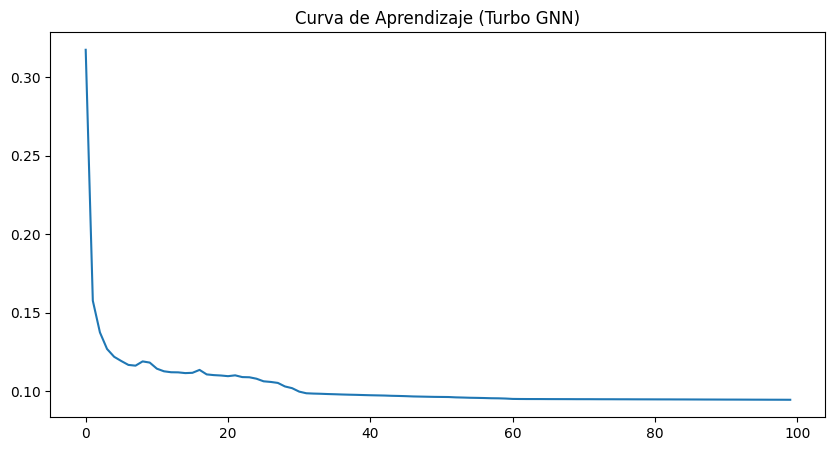

In [10]:

# --- ENTRENAMIENTO TURBO (AMP + Vectorized) ---
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

scaler = GradScaler()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)

print(f"Iniciando entrenamiento TURBO en: {DEVICE}")
train_losses = []

model.train()
torch.backends.cudnn.benchmark = True # Optimize CUDNN algorithms

for epoch in range(EPOCHS):
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for x, t, y in pbar:
        x, t, y = x.to(DEVICE), t.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Mixed Precision Context
        with autocast():
            # edge_index (adj) is global constant, passed as base
            output = model(x, t, edge_index)
            loss = criterion(output, y)
        
        # Scaled Backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.5f}"})
    
    scheduler.step()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")
    
    # Clean Cache to prevent fragmentation
    torch.cuda.empty_cache()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Curva de Aprendizaje (Turbo GNN)')
plt.show()


## 5. Interpretación de Resultados

### 5.1. Métricas de Evaluación
Para evaluar el rendimiento, primero se **desnormalizan** las predicciones para volver a la escala original de tráfico (número de SMS).

$$ \hat{X}_{orig} = \hat{X}_{norm} \cdot (Max - Min) + Min $$

Se calculan las siguientes métricas:

1.  **RMSE (Root Mean Squared Error)**: Error cuadrático medio. Penaliza más los errores grandes.
    $$ RMSE = \sqrt{\frac{1}{M} \sum (\hat{x}_{orig} - x_{orig})^2} $$

2.  **MAE (Mean Absolute Error)**: Error absoluto medio. Es más robusto a outliers y fácil de interpretar (error promedio en SMS).
    $$ MAE = \frac{1}{M} \sum |\hat{x}_{orig} - x_{orig}| $$

3.  **R2 Score**: Coeficiente de determinación. Indica qué tan bien las predicciones se ajustan a los datos reales (1.0 es perfecto).

### 5.2. Visualización
*   **Scatter Plot**: Gráfico de dispersión de Predicción vs Realidad. Idealmente, los puntos deberían alinearse en la diagonal.
*   **Distribución de Errores**: Histograma de los residuos. Debería estar centrado en 0.
*   **Mapa de Calor de Error**: Muestra dónde se concentran los errores espacialmente.
*   **Serie Temporal**: Comparación visual de la predicción y la realidad a lo largo del tiempo para una celda específica.

Evaluando modelo ST-GNN...


Testing: 100%|████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.55it/s]



Resultados de Evaluación (ST-GNN):
RMSE: 128.8455
MAE:  50.2248
R2:   0.8799
WMAPE: 20.7181%
Accuracy: 79.2819%
Visualizando nodo crítico (Max Tráfico): 5160


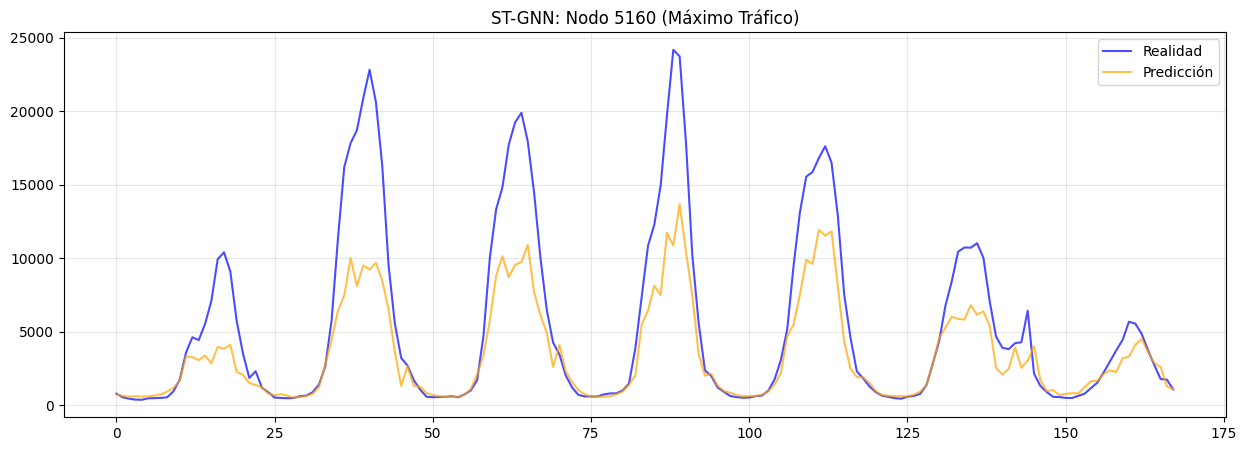

Visualizando 10 celdas aleatorias: [1654 4672 9921 5500  304 5941 3560 7443 9904 8562]


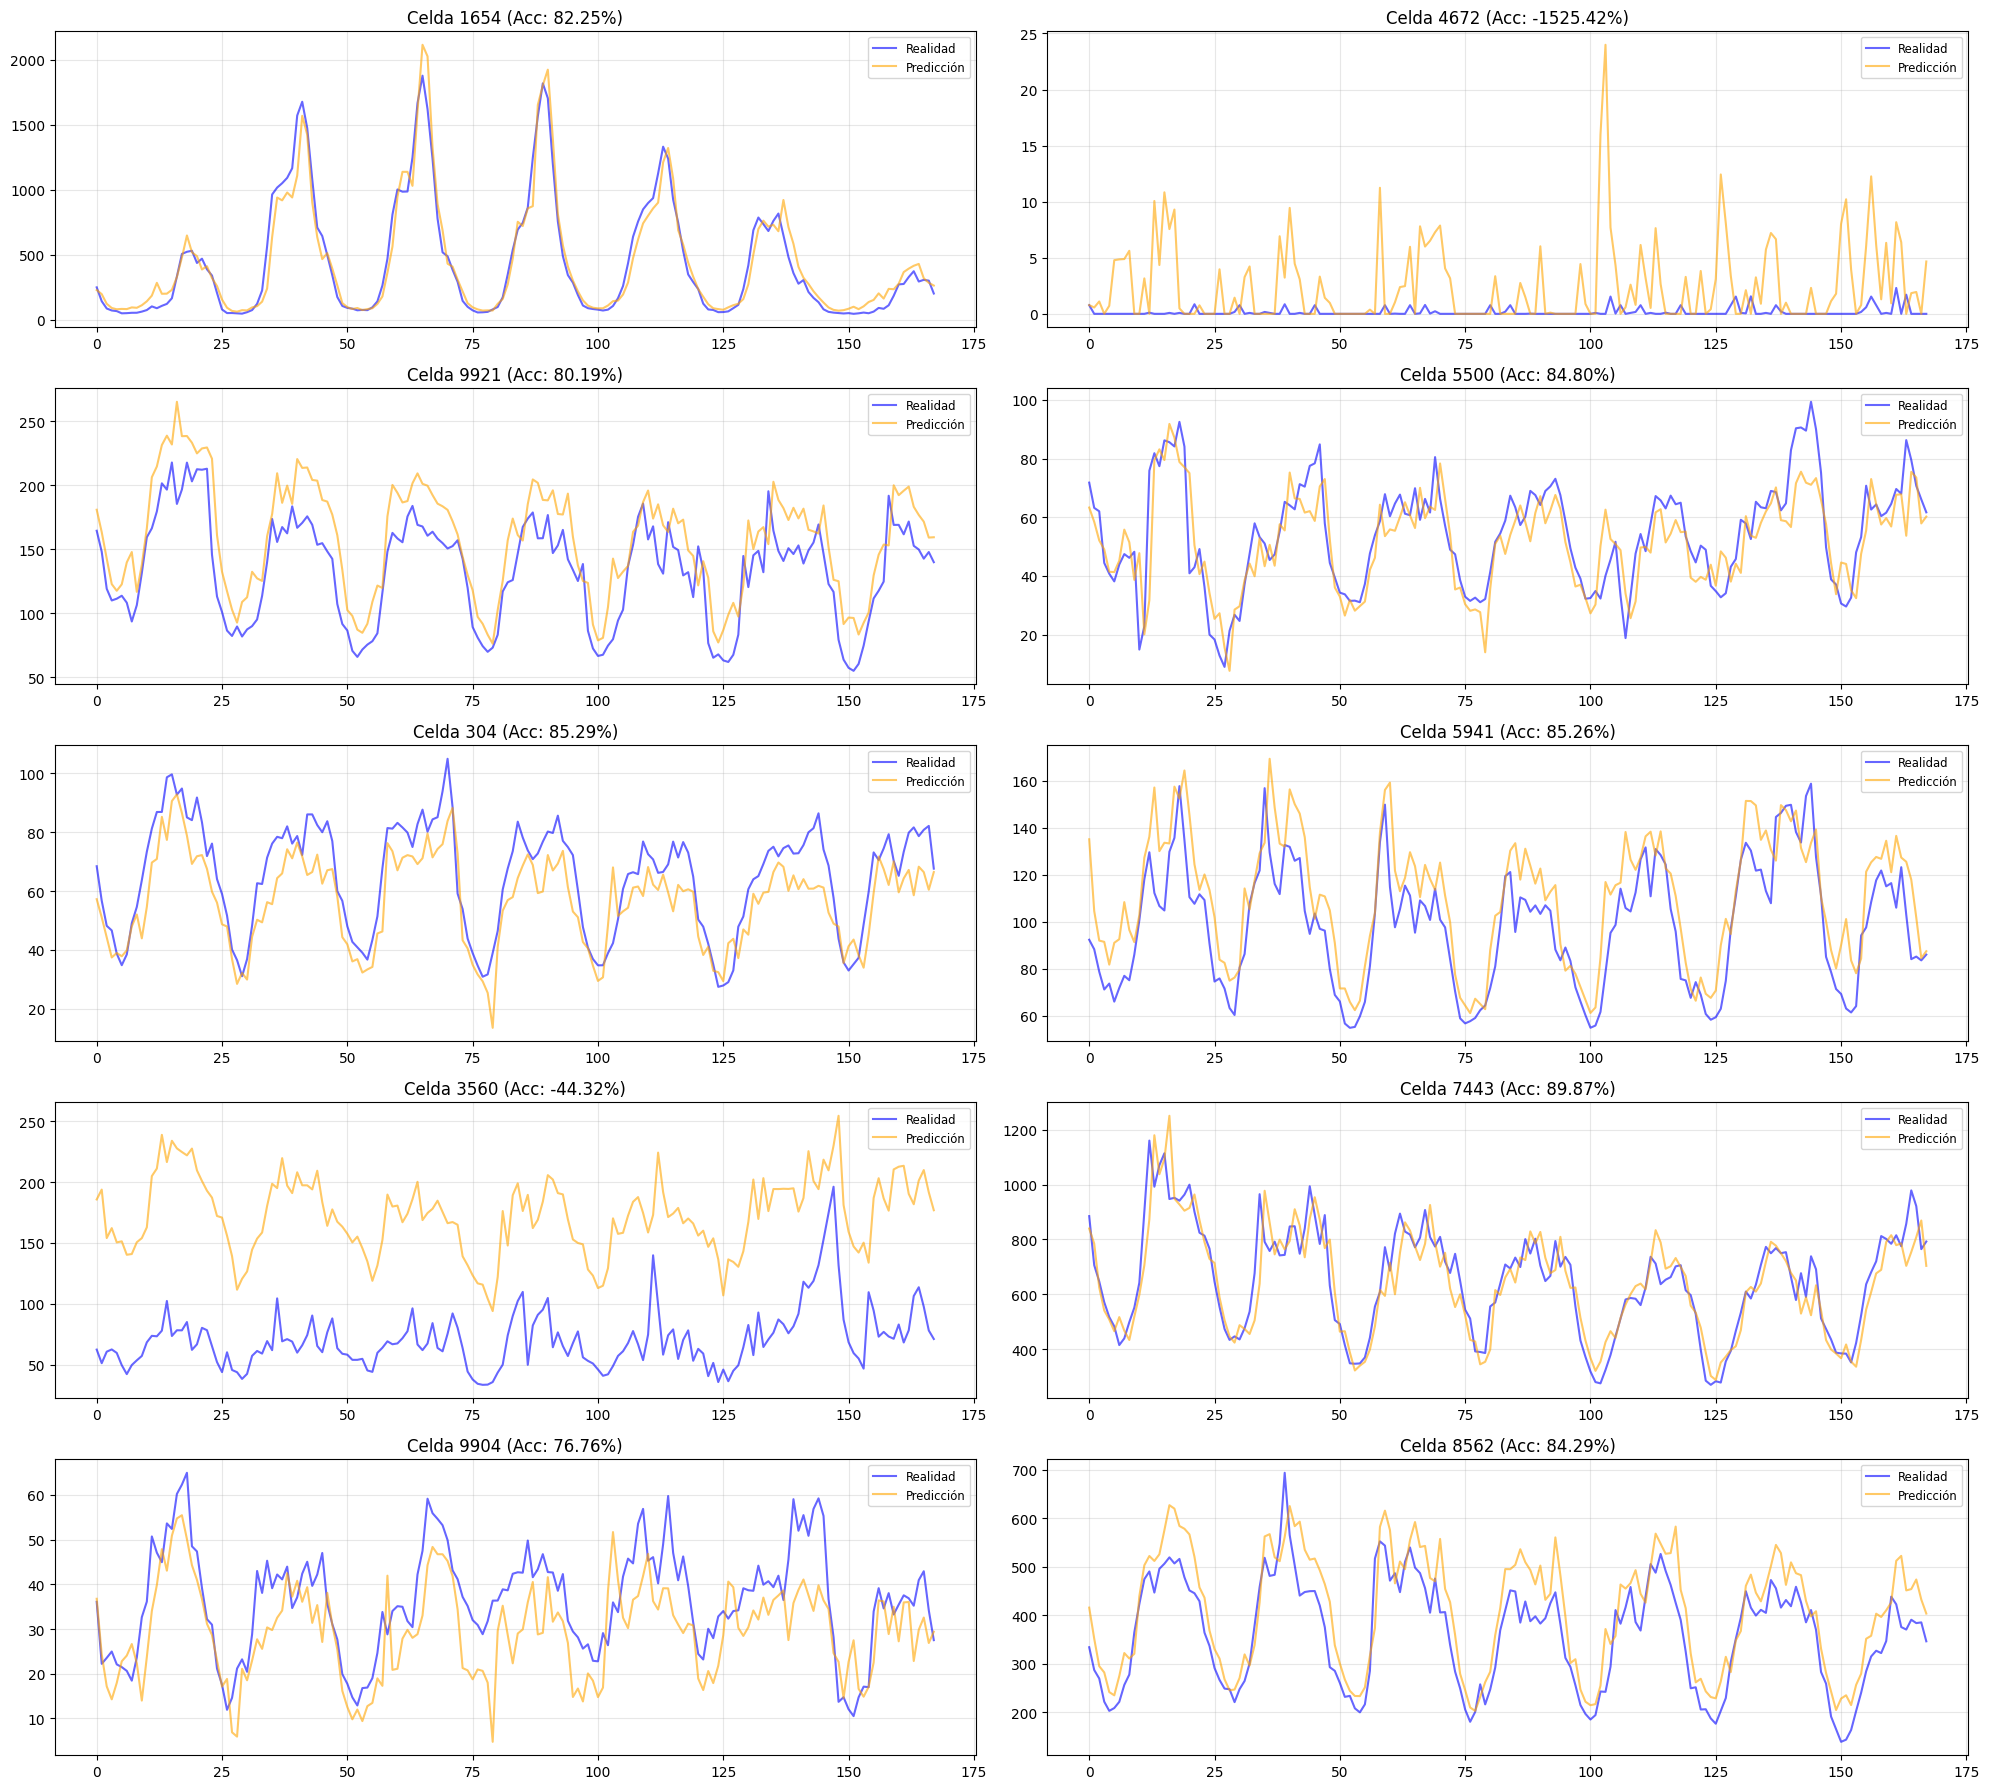

In [11]:
# --- EVALUACIÓN ROBUSTA (ST-GNN) ---
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optimización inicial de memoria
torch.cuda.empty_cache()
gc.collect()

model.eval()
predictions = []
ground_truth = []

print("Evaluando modelo ST-GNN...")
with torch.no_grad():
    for x, t, y in tqdm(test_loader, desc="Testing"):
        x, t, y = x.to(DEVICE), t.to(DEVICE), y.to(DEVICE)
        output = model(x, t, edge_index)
        
        # Guardar en CPU como float32 para liberar VRAM inmediatamente
        predictions.append(output.cpu().numpy().astype(np.float32))
        ground_truth.append(y.cpu().numpy().astype(np.float32))
        
        del output

# Reconstrucción de resultados
preds = np.concatenate(predictions, axis=0)
gt = np.concatenate(ground_truth, axis=0)
del predictions, ground_truth
gc.collect()

# Des-normalización Z-Score (usando tus variables traffic_mean/std)
preds_orig = preds * traffic_std + traffic_mean
gt_orig = gt * traffic_std + traffic_mean
preds_orig = np.maximum(preds_orig, 0) # No permitir tráfico negativo

# Métricas Globales (Aplanadas)
preds_flat = preds_orig.flatten()
gt_flat = gt_orig.flatten()

rmse = np.sqrt(mean_squared_error(gt_flat, preds_flat))
mae = mean_absolute_error(gt_flat, preds_flat)
r2 = r2_score(gt_flat, preds_flat)
wmape = np.sum(np.abs(gt_flat - preds_flat)) / (np.sum(np.abs(gt_flat)) + 1e-7)
accuracy = 1 - wmape

print("\nResultados de Evaluación (ST-GNN):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")
print(f"WMAPE: {wmape:.4%}")
print(f"Accuracy: {accuracy:.4%}")

# Liberar memoria de arrays aplanados antes de las gráficas
del preds_flat, gt_flat
gc.collect()

# --- VISUALIZACIÓN ---

# 1. Nodo con mayor tráfico promedio
mean_traffic_per_node = gt_orig.mean(axis=0).flatten()
max_node_idx = np.argmax(mean_traffic_per_node)
print(f"Visualizando nodo crítico (Max Tráfico): {max_node_idx}")

plt.figure(figsize=(15, 5))
plt.plot(gt_orig[:, max_node_idx, 0], label='Realidad', color='blue', alpha=0.7)
plt.plot(preds_orig[:, max_node_idx, 0], label='Predicción', color='orange', alpha=0.7)
plt.title(f'ST-GNN: Nodo {max_node_idx} (Máximo Tráfico)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Rejilla de 10 Celdas Aleatorias
num_plots = 10
total_nodes = gt_orig.shape[1]
random_indices = np.random.choice(total_nodes, size=num_plots, replace=False)
print(f"Visualizando {num_plots} celdas aleatorias: {random_indices}")

fig, axes = plt.subplots(5, 2, figsize=(20, 18))
axes = axes.flatten()

for i, node_idx in enumerate(random_indices):
    ax = axes[i]
    ax.plot(gt_orig[:, node_idx, 0], label='Realidad', color='blue', alpha=0.6)
    ax.plot(preds_orig[:, node_idx, 0], label='Predicción', color='orange', alpha=0.6)
    
    # Cálculo de Accuracy local para este nodo
    local_err = np.sum(np.abs(gt_orig[:, node_idx] - preds_orig[:, node_idx]))
    local_sum = np.sum(np.abs(gt_orig[:, node_idx]))
    local_acc = 1 - (local_err / (local_sum + 1e-7))
    
    ax.set_title(f'Celda {node_idx} (Acc: {local_acc:.2%})')
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

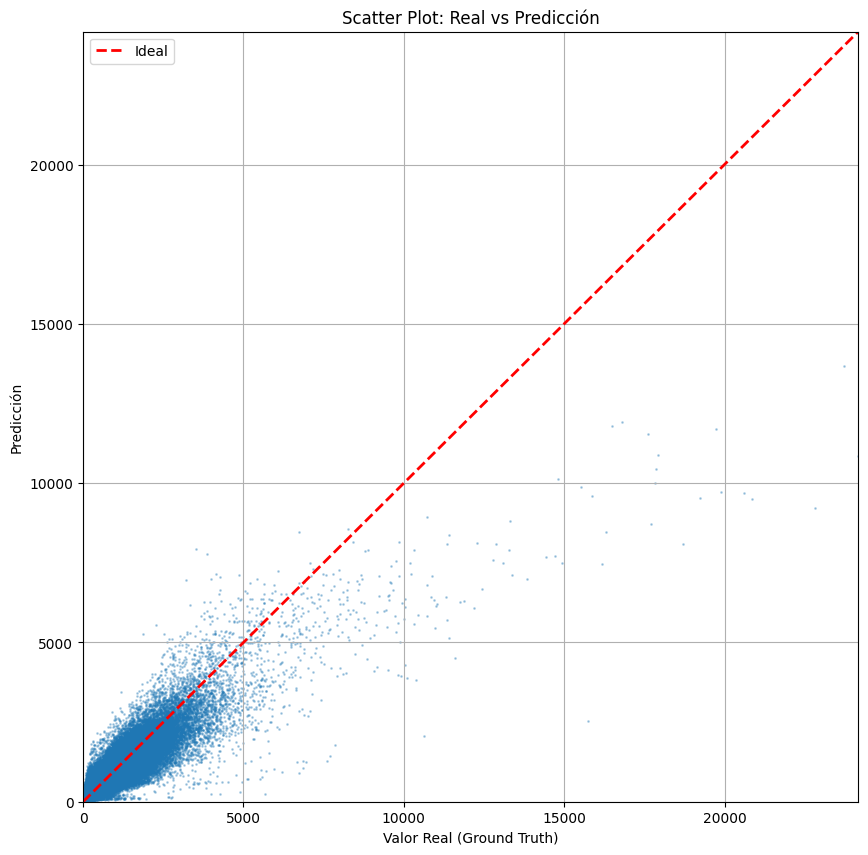

In [12]:
# --- Visualización: Real vs. Predicción (Scatter Plot) ---
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
plt.scatter(gt_orig.flatten(), preds_orig.flatten(), alpha=0.3, s=1)

# Línea ideal (y = x) partiendo desde 0
max_val = max(gt_orig.max(), preds_orig.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Ideal')

plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.xlabel('Valor Real (Ground Truth)')
plt.ylabel('Predicción')
plt.title('Scatter Plot: Real vs Predicción')
plt.legend()
plt.grid(True)
plt.show()